Author: 

In [2]:
import warnings

warnings.filterwarnings("ignore")  # silence warnings

Loan is the main profit source for a bank with the profit mainly generated from the interest paid on the loan. Inorder to get this process profitable, the bank needs to know if the loan applicant will be able to pay back the loan along with the interest. Inorder to make this decision, in this article, we discuss the Bayesian Network way of predicting the eligibility of the loan applicant.  In doing so we will discuss about how different variables are involved to understand the causal relationship which helps us to find the conditional probability for different states of the variables in the network. 

The task is learn a Bayesian Network for finding the loan elligibility for the applicant who wants to buy a Property in one of the three different areas. 



# Data Exploration and Preprocessing

Before starting with Baysian Network learning, we need to explore the dataset and preprocess it for the task in hand. We are going to be using the loan eligibility dataset at https://github.com/mridulrb/Predict-loan-eligibility-using-IBM-Watson-Studio/tree/master/Dataset

For our purposes, we are going to use pandas for loading the csv files in the provided dataset. We are going to load train set to form one dataframe called "data". In this case, we are not using test file and will make data for testing from samples in train file since test file does not have the ground truth. We do this for preprocessing all the data together. Later for inference using BN, we are going to split this data into test and train dataframes.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
data=pd.read_csv("Loan_data.csv")

In [4]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We can use the data.head() command to see the top few rows of the loaded dataframe. This gives us an idea about different variables involved. A quick look at "LoanAmount" shows that there are also missing values in the dataset labelled with Nan. This is normally the case and we first need to find out the missing values for each of the variables and then fill them up.

For this purpose, we are going to apply isnull function using the code given in the cell below, which finds the missing values for each variable in the dataset

In [5]:
data.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We can see that some of the variables have missing values. Depending upon the type of variable, we are going to use mode for categorical variables for filling missing values and mean for filling numerical variables.

In [6]:
#categorical
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
#numerical
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)

In this work, we are going to be utilzing the Bayesian Network Strucuture learning method of causalNex for learning the causal relationships between the variables. Although, for the case of loan eligibility problem and in general, there is a need for domain knowledge for setting up the structure of the BN but first we are going to use the inbuilt algorithms in causalNex to demonstrate autmatic learning using causalNex. Later on, we will use domain knowledge for Loan eligibility to setup a structure for BN. The structure leanring function of causalNex requires the data to be in numeric form so we are going to first convert the data for this purpose.

We begin by finding the columns which have categorical form and the following code snippet can be used to extract the columns that corresspond to categorical variables

In [7]:
drop_col = ['Loan_ID']
data = data.drop(columns=drop_col)

In [8]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


For this work, we are also going to convert the numerical variables into categories for causelNex implementation. For this data, we have the following variables currently corressponding to numerical variables:

LoanAmount

ApplicantIncome

Coapplicantincome

Loan_Amount_Term


First, for the sake of easy demonstration, we are going sum the ApplicantIncome and Coapplicantincome into one variable called TotalIncome and drop the variables ApplicantIncome and CoapplicantIncome from the overall data. The following code snippet can be used for this purpose.

In [9]:
struct_data['TotalIncome']= struct_data['ApplicantIncome'] +struct_data['CoapplicantIncome'] 
drop_col = ['ApplicantIncome','CoapplicantIncome']
struct_data = struct_data.drop(columns=drop_col)

Inorder to ultimately convert the numerical variables into catergorical, we first need to discretize the numerical variables. Inorder to box thse variables into discrete bins, we first need to decide the bin boundaries. For this purpose we are going to use boxplot and hitogram to visualize these variables

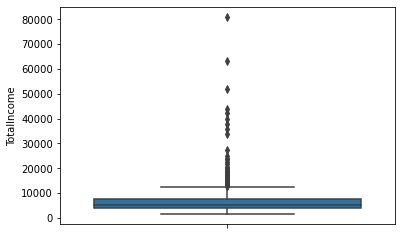

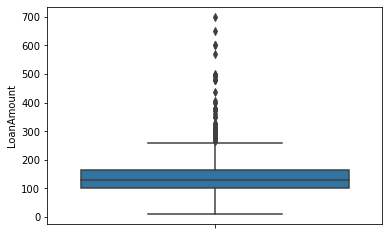

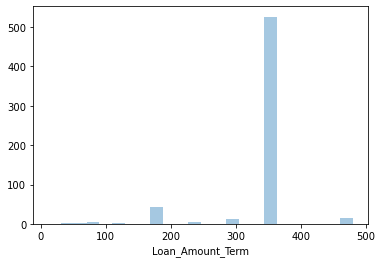

In [10]:
sns.boxplot(y='TotalIncome',data=struct_data)
plt.figure()
sns.boxplot(y='LoanAmount',data=data)
plt.figure()
sns.distplot(data.Loan_Amount_Term.dropna(),kde=False)
plt.show()




We can see from the above plots that the following boundaries can be used for the variables:

TotalIncome = [15000,50000]

LoanAmount = [200,550]

Loan_Amount_Term = [365]


Now that we have the boundaries, we need to convert the variables into descretized values

In [11]:

discretised_data = struct_data.copy()

discretised_data["TotalIncome"] = np.digitize(discretised_data["TotalIncome"],[15000,50000])
discretised_data["LoanAmount"] = np.digitize(discretised_data["LoanAmount"],[200,550])
discretised_data["Loan_Amount_Term"] = np.digitize(discretised_data["Loan_Amount_Term"],[365])

After descrtising the data, we can then map the bins into different categories. We use three different categories for TotalIncome & LoanAmount i.e low, medium, high and two categories for Loan_Amount_Term.

In [12]:
income_map = {0: "low", 1: "med", 2: "High"}
loan_term_map = {0:"short",1:"long"}
discretised_data["TotalIncome"] = discretised_data["TotalIncome"].map(income_map)
discretised_data["LoanAmount"] = discretised_data["LoanAmount"].map(income_map)
discretised_data["Loan_Amount_Term"] = discretised_data["Loan_Amount_Term"].map(loan_term_map)
discretised_data_copy = discretised_data.copy() 

In [13]:
discretised_data.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,low,short,1.0,Urban,Y,low
1,Male,Yes,1,Graduate,No,low,short,1.0,Rural,N,low
2,Male,Yes,0,Graduate,Yes,low,short,1.0,Urban,Y,low
3,Male,Yes,0,Not Graduate,No,low,short,1.0,Urban,Y,low
4,Male,No,0,Graduate,No,low,short,1.0,Urban,Y,low


We can now use the non-numeric variables and map them into numeric form since the BN structure learning model requries numeric variables

In [39]:
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(discretised_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    discretised_data[col] = le.fit_transform(discretised_data[col])
discretised_data["Credit_History"] = discretised_data["Credit_History"].astype(int)

discretised_data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,1,0,0,0,0,1,1,1,2,1,1
1,1,1,1,0,0,1,1,1,0,0,1
2,1,1,0,0,1,1,1,1,2,1,1
3,1,1,0,1,0,1,1,1,2,1,1
4,1,0,0,0,0,1,1,1,2,1,1


# Bayesian Network Structure Learning

Now that we have preprocessed the data, we can start to build models using the DoWhy library which we will install below.

In [15]:
import graphviz

digraph {
	LoanAmount [label=LoanAmount]
	Self_Employed [label=Self_Employed]
	Education [label=Education]
	Loan_Status [label=Loan_Status]
	Loan_Amount_Term [label=Loan_Amount_Term]
	Property_Area [label=Property_Area]
	Credit_History [label=Credit_History]
	TotalIncome [label=TotalIncome]
	Education -> TotalIncome
	Self_Employed -> TotalIncome
	TotalIncome -> Loan_Status
	Loan_Amount_Term -> Loan_Status
	Credit_History -> Loan_Status
	LoanAmount -> Loan_Status
	Property_Area -> LoanAmount
}



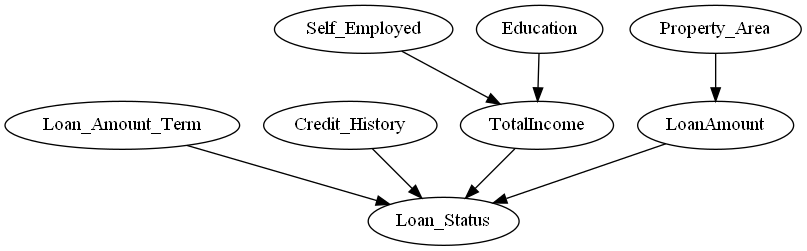

In [16]:
from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.node('LoanAmount', 'LoanAmount')  
dot.node('Self_Employed', 'Self_Employed')
dot.node('Education', 'Education')
dot.node('Loan_Status', 'Loan_Status')
 
dot.node('Loan_Amount_Term','Loan_Amount_Term')
dot.node('Property_Area', 'Property_Area')
dot.node('Credit_History', 'Credit_History')
dot.node('TotalIncome', 'TotalIncome')


dot.edge('Education', 'TotalIncome')
dot.edge('Self_Employed', 'TotalIncome')
dot.edge('TotalIncome', 'Loan_Status')
dot.edge('Loan_Amount_Term', 'Loan_Status')
dot.edge('Credit_History', 'Loan_Status')
dot.edge('LoanAmount', 'Loan_Status')
dot.edge('Property_Area', 'LoanAmount')

print(dot.source)

dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="Digraph.gv.png"))

Now we can test basic digraphs for our data.

"sm" contains the structure of BN showing the causal relationships. It should be noted that learning the BN structure can have unexpected results and it is recommended to add domain knowledge to the overall problem. 

To visualize the the BN, we can use the following code snipet. It can be seen that we are keep a threshold of 0.5 using sm.remove_edges_below_threshold(0.5) which removes any edge with lesser than a certain weight.


In [40]:
print(discretised_data['Credit_History'].unqiue())

AttributeError: 'Series' object has no attribute 'unqiue'

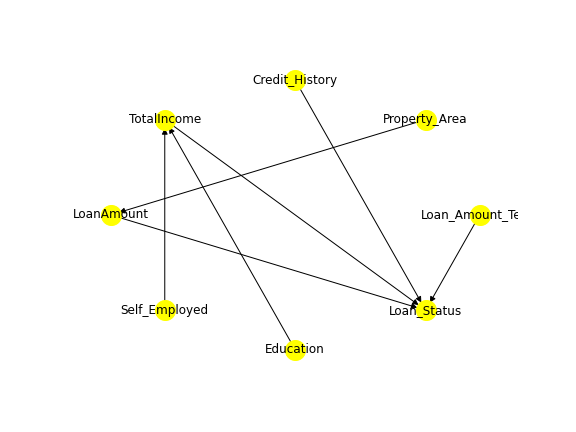

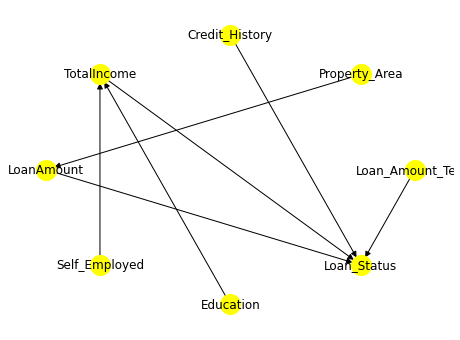

In [58]:
import dowhy

from dowhy import CausalModel


model = dowhy.CausalModel(data=discretised_data,                    
                     graph=dot.source.replace("\t", ' ').replace("\n", ' '),
                     treatment = 'Credit_History',
                     common_causes = ['LoanAmount','Loan_Amount_Term','TotalIncome'],
                     outcome="Loan_Status")
model.view_model() 

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

It can be seen that the causal relationship is not what we expect. The Total Income for example should be affecting the Loan_Status. Since the algorithm does not have this information, it is always recommendaed to add domain knowledge for structure learning. We can add and remove edges as follow:

sm.add_edge("Variable_parent", "Variable_child")

sm.remove_edge("Variable_parent", "Variable_child")

We can also add constrainsts as explained earlier or in some cases we can get the largest subgraph using the following command: 


sm = sm.get_largest_subgraph()


In this case, we are going to define the BN structure by our self with the help of domain knowledge

The following code snipet defines the graph and visualizes it

In [59]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                        
─────────────────(E[Loan_Status])
d[Credit_History]                
Estimand assumption 1, Unconfoundedness: If U→{Credit_History} and U→Loan_Status then P(Loan_Status|Credit_History,,U) = P(Loan_Status|Credit_History,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [61]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",
                                target_units="att")
print({estimate.value})
val_est_rcc=model.refute_estimate(identified_estimand,estimate,method_name="random_common_cause")
print(val_est_rcc)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{0.7110373935092399}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals'

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effec

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effec

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['TotalIncome', 'LoanAmount', 'Education', 'Property_Area', 'Self_Employed', 'Loan_Amount_Term']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effec

The assumptions can be seen from the visualization above. We assume that loan eligibility is affected using the direction of the edges. In this problem, we have removed gender's affect and leave it up to the reader to explore benefit of adding the gender variable to the problem.

# Bayesian Network Inference

We can start by intiating the inference object by providing the above BN structure. We can instantiate a BayesianNetwork.



In [21]:

est_psm = model.estimate_effect(est_ident,method_name="backdoor.propensity_score_matching")

val_est_rcc=model.refute_estimate(est_ident,est_psm,method_name="random_common_cause")
print(val_est_rcc)

propensity_score_matching


Exception: No common causes/confounders present. Propensity score based methods are not applicable

With the learnt structure model from earlier and also the discretised data, we will now fit the probability distrbution of the Bayesian Network.The first step is specifying all of the states that every node can take. This can be done either from data, or providing a dictionary of node values. We use the complete dataset here to avoid cases where states in our test set don't exist within the training set. For real-world applications, these states might have to be provided using the dictionary method.

In [19]:
bn = bn.fit_node_states(discretised_data)

As mentioned earlier, we are going to split the test and train data for evaluating the learnt BN.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

The fit_cpds method of BayesianNetwork accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit [1]. Furthermore, we can use bn.cpds["Loan_Status"] for checking the learnt conditional probabilities 

In [21]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [22]:
bn.cpds["Loan_Status"]

Credit_History    0.0                                                    ...  \
LoanAmount          0                                  1                 ...   
Loan_Amount_Term    0              1                   0              1  ...   
TotalIncome         0    1    2    0    1         2    0    1    2    0  ...   
Loan_Status                                                              ...   
0                 0.5  0.5  0.5  0.5  0.5  0.333333  0.5  0.8  0.5  0.5  ...   
1                 0.5  0.5  0.5  0.5  0.5  0.666667  0.5  0.2  0.5  0.5  ...   

Credit_History    1.0                                                    \
LoanAmount          1                             2                       
Loan_Amount_Term    0    1                        0                   1   
TotalIncome         2    0         1         2    0    1    2         0   
Loan_Status                                                               
0                 0.5  0.5  0.192708  0.181818  0.5  0.5  0.5  0.333333   
1                 0.5  0.5  0.807292  0.818182  0.5  0.5  0.5  0.666667   

Credit_History                   
LoanAmount                       
Loan_Amount_Term                 
TotalIncome              1    2  
Loan_Status                      
0                 0.245283  0.5  
1                 0.754717  0.5  

[2 rows x 36 columns]

Lets use an example to see how the BN is performing

In [23]:
discretised_data_copy.loc[18, discretised_data.columns != 'Loan_Status']

Gender                      Male
Married                      Yes
Dependents                     0
Education           Not Graduate
Self_Employed                 No
LoanAmount                   low
Loan_Amount_Term           short
Credit_History                 1
Property_Area              Rural
TotalIncome                  low
Name: 18, dtype: object

In the above example, we have an applicant with medium range Income needing property in Rural area. The loan term is short with low loan Amount as well and good credit history. Normally such application are given the loan. 

We can use bn.predict for Loan_Status

In [24]:
predictions = bn.predict(discretised_data, "Loan_Status")
print(f"The prediction is '{predictions.loc[50, 'Loan_Status_prediction']}'")


The prediction is '1'


In [25]:
print(f"The ground truth is '{discretised_data.loc[50, 'Loan_Status']}'")


The ground truth is '1'


The above example demonstrate the inference by the learnt BN. It should be noted, that the BN also helps us interpret the results with the help of relationships between different variables in the BN. 

Inorder to fully evaluate the BN model, we are going to use the classification_report object from the causalnex which helps us get the precision, recall and Accuracy for different classes.

In [26]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "Loan_Status")

{'Loan_Status_0': {'precision': 0.8181818181818182,
  'recall': 0.47368421052631576,
  'f1-score': 0.6,
  'support': 19},
 'Loan_Status_1': {'precision': 0.803921568627451,
  'recall': 0.9534883720930233,
  'f1-score': 0.8723404255319148,
  'support': 43},
 'accuracy': 0.8064516129032258,
 'macro avg': {'precision': 0.8110516934046346,
  'recall': 0.7135862913096696,
  'f1-score': 0.7361702127659574,
  'support': 62},
 'weighted avg': {'precision': 0.8082916451037894,
  'recall': 0.8064516129032258,
  'f1-score': 0.7888812628689087,
  'support': 62}}

From the report above, we can see that precision and recall for giving loan to an applicant is high. This means that we can rely on the predictions for this class made by the model because of precision with lesser chance of missing the predictions which we should have made. The recall for an applicant not being elligible for loan is low which can be due to something missing in the BN structure and something to explore later.


The overall Area Under the ROC Curve (AUC) is obtained using the code snippet below which comes with the CauselNex.

In [28]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "Loan_Status")
print(auc)

0.8404006243496359


To summarize, given that we have the processed loan dataset, we start by learning the causal relationships between different loan features in the form of the network structure in which we can add constraints to the connections between nodes using the bank’s professional knowledge. Once we have the causal relationships, we can use the train split of the data to learn the conditional probabilities for different states which in the end gives us the conditional probability to estimate the risk of giving a loan to a certain loan applicant. To evaluate the model, we can use ROC/AUC on the test dataset.